Dataset loaded successfully!
Columns in the dataset:
Index(['category', 'rating', 'label', 'text_'], dtype='object')

Counts of each column:
category    43432
rating      43127
label       43432
text_       43231
dtype: int64


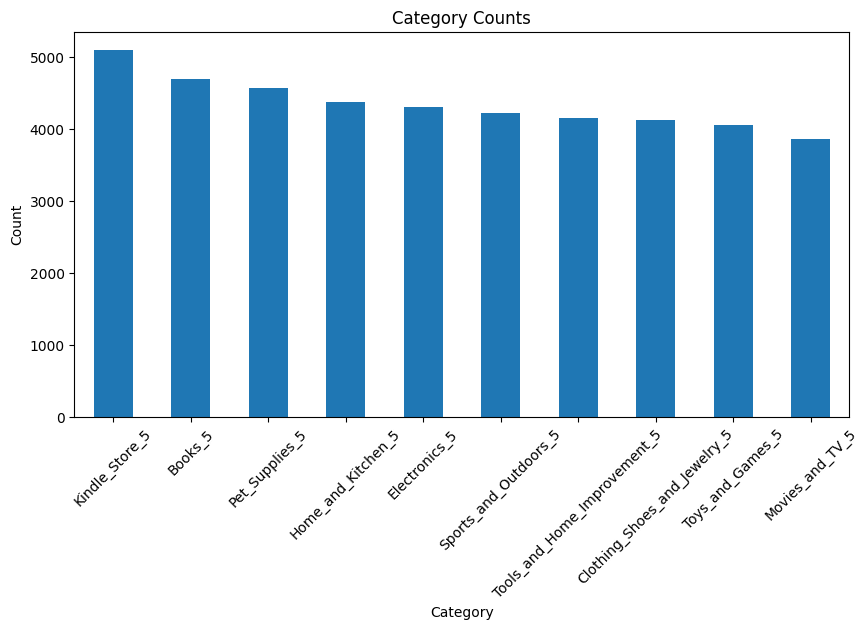

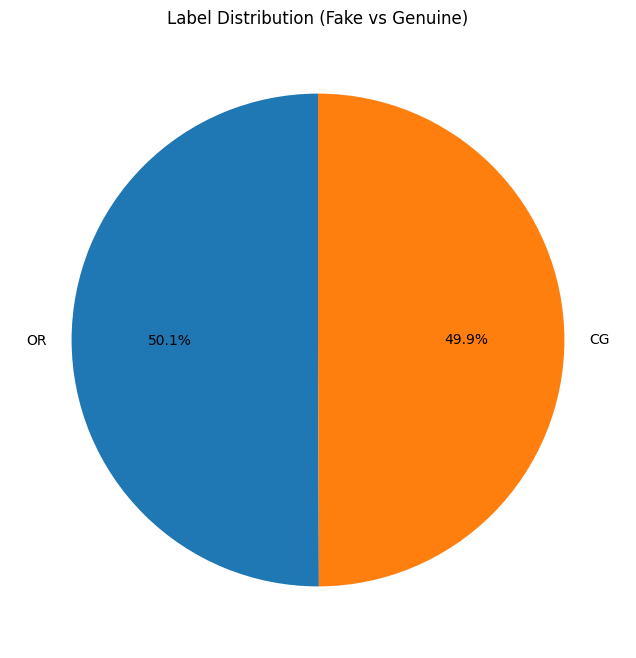

<Figure size 1400x700 with 0 Axes>

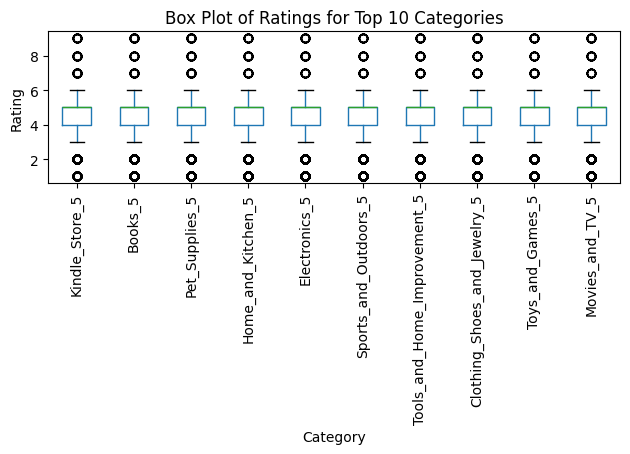

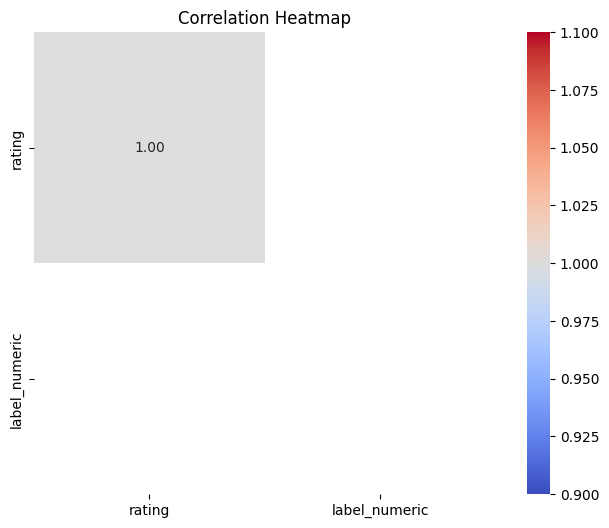

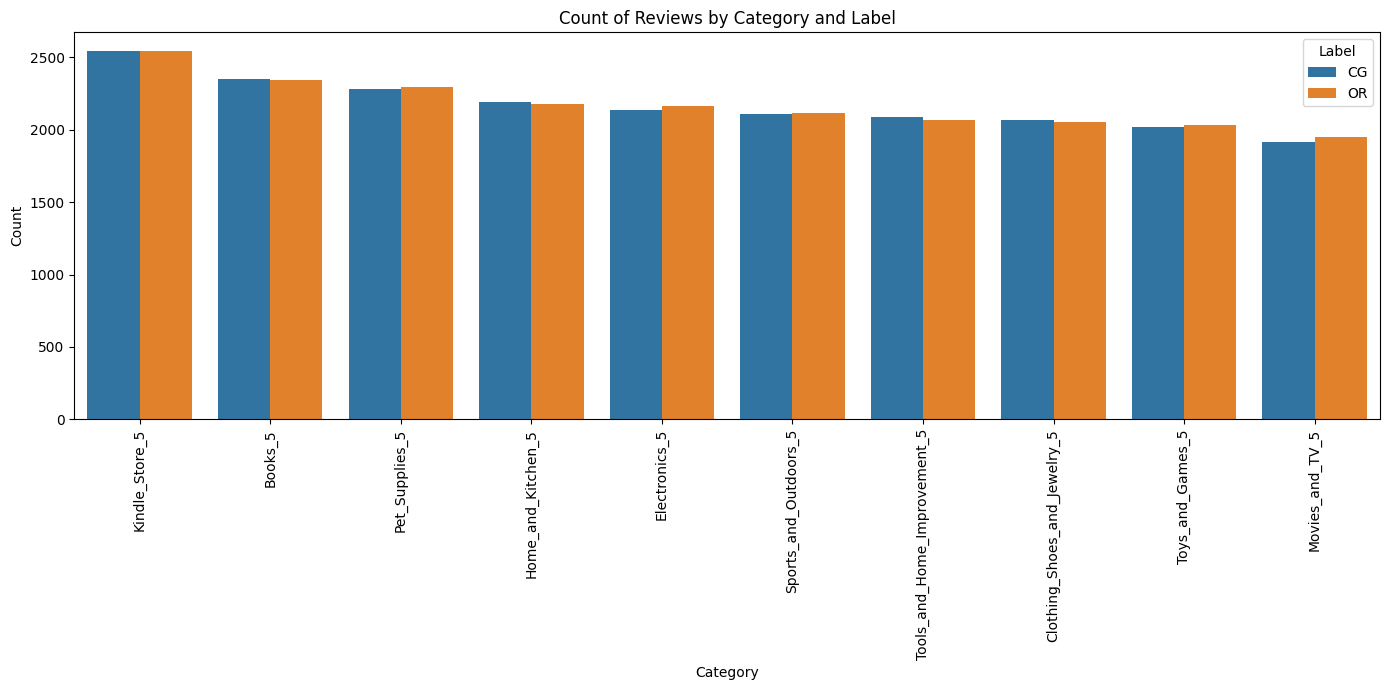

Shape of the cleaned DataFrame: (41660, 5)
Cleaned Text:
                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                        text_cleaned  
0  love this  well made sturdy and very comfortab...  
1  love it a great upgrade from the original  ive...  
2  this pillow saved my back i love the look and ...  
3  missing information on how to use it but it is...  
4  very nice set good quality we have had the set...  

Tokenized and Stopwords Removed:
                                        text_cleaned  \
0  love this  well made sturdy and very comfortab...   
1  love it a great upgrade from the original  ive...   
2  this pillow saved my back i love the look and ...   
3  missing informa

In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Load the Dataset from your local file system
file_path = './fake_reviews_with_erroneous_data.csv'  # Use a raw string to avoid escape issues
df = pd.read_csv(file_path)

# Display the first few rows and the columns of the dataset
print("Dataset loaded successfully!")
print("Columns in the dataset:")
print(df.columns)

# Display counts of each column
print("\nCounts of each column:")
print(df.count())

# Bar Chart of Category Counts
plt.figure(figsize=(10, 5))
df['category'].value_counts().plot(kind='bar')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Pie Chart of Label Distribution
plt.figure(figsize=(8, 8))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution (Fake vs Genuine)')
plt.ylabel('')
plt.show()

# Count the occurrences of each category and select the top N categories
top_n = 10
top_categories = df['category'].value_counts().nlargest(top_n).index

# Create a new dataframe with only the top categories
filtered_df = df[df['category'].isin(top_categories)]

# Set the category order
filtered_df['category'] = pd.Categorical(filtered_df['category'], categories=top_categories, ordered=True)

# Box Plot of Ratings for Top Categories
plt.figure(figsize=(14, 7))
filtered_df.boxplot(column='rating', by='category', grid=False)
plt.title(f'Box Plot of Ratings for Top {top_n} Categories')
plt.suptitle('')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Convert 'label' to a numerical format for correlation calculation
df['label_numeric'] = df['label'].map({'genuine': 1, 'fake': 0})  # Adjust according to your label values

# Calculate the correlation matrix
correlation_matrix = df[['rating', 'label_numeric']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Count Plot of Labels by Category
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='category', hue='label', order=df['category'].value_counts().index)
plt.title('Count of Reviews by Category and Label')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Label', loc='upper right')
plt.tight_layout()
plt.show()

# Handle missing values
# Drop rows where 'text_' or 'label' are NaN, if any
df_cleaned = df.dropna(subset=['text_', 'label'])

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Display the shape of the cleaned DataFrame
print("Shape of the cleaned DataFrame:", df_cleaned.shape)

# Use scikit-learn's stop words
stop_words = ENGLISH_STOP_WORDS

# Function to clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the cleaning function to the 'text_' column
df_cleaned['text_cleaned'] = df_cleaned['text_'].apply(clean_text)

# Display the first few rows of the cleaned text
print("Cleaned Text:")
print(df_cleaned[['text_', 'text_cleaned']].head())

# Function to tokenize and remove stop words
def preprocess_text(text):
    # Split text into tokens by whitespace
    tokens = text.split()
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Apply the preprocessing function to the cleaned text
df_cleaned['text_tokenized'] = df_cleaned['text_cleaned'].apply(preprocess_text)

# Display the first few rows of the tokenized text
print("\nTokenized and Stopwords Removed:")
print(df_cleaned[['text_cleaned', 'text_tokenized']].head())

# Vectorization (Using TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into sentences for TF-IDF
df_cleaned['lemmatized_text'] = df_cleaned['text_tokenized'].apply(lambda x: ' '.join(x))

# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_cleaned['lemmatized_text'])

# Save the cleaned DataFrame for further training
df_cleaned.to_csv('./cleaned_fake_reviews_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_fake_reviews_dataset.csv'")


In [3]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import time

# Load your dataset
cleaned_df = pd.read_csv('./cleaned_fake_reviews_dataset.csv')
cleaned_df['text_'] = cleaned_df['text_'].astype(str)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the review text
def tokenize_text(text):
    return tokenizer(text, padding='max_length', max_length=128, truncation=True, return_tensors='pt')

# Apply tokenization on the review column
cleaned_df['tokens'] = cleaned_df['text_'].apply(lambda x: tokenize_text(x))

# Convert the labels to integers (if not already)
label_map = {'CG': 0, 'OR': 1}  # CG: Fake, OR: Real (modify as per your label encoding)
cleaned_df['label'] = cleaned_df['label'].map(label_map)

# Prepare inputs and labels
input_ids = torch.cat([x['input_ids'] for x in cleaned_df['tokens']])
attention_masks = torch.cat([x['attention_mask'] for x in cleaned_df['tokens']])
labels = torch.tensor(cleaned_df['label'].values)

# Split the data into train, validation, and test sets
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2, random_state=42
)

val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    test_inputs, test_labels, test_masks, test_size=0.5, random_state=42
)

# Print dataset sizes
print(f"Train size: {len(train_inputs)}, Validation size: {len(val_inputs)}, Test size: {len(test_inputs)}")

# Convert to PyTorch tensors
train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
val_data = torch.utils.data.TensorDataset(val_inputs, val_masks, val_labels)
test_data = torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels)

train_sampler = torch.utils.data.RandomSampler(train_data)
val_sampler = torch.utils.data.SequentialSampler(val_data)
test_sampler = torch.utils.data.SequentialSampler(test_data)

train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_data, sampler=val_sampler, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=32)

# Define the BERT + LSTM model class
class BERT_LSTM_Model(nn.Module):
    def __init__(self):
        super(BERT_LSTM_Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, 1)  # Fully connected layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Pass input through BERT model
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state  # Get embeddings
        # Pass BERT embeddings into LSTM
        lstm_output, _ = self.lstm(cls_output)
        # Get the last output from the LSTM (many-to-one approach)
        lstm_output = lstm_output[:, -1, :]
        # Pass through fully connected layer and sigmoid activation
        fc_output = self.fc(lstm_output)
        return self.sigmoid(fc_output)

# Initialize the model
model = BERT_LSTM_Model()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training and validation functions with progress bar and metric tracking
def train(model, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(10):  # Adjust epochs as needed
        print(f"Epoch {epoch+1}")
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        # Training loop with progress bar
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1} Training", unit="batch") as pbar:
            for batch in train_dataloader:
                input_ids, attention_mask, labels = batch
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.squeeze(), labels.float())
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

                # Calculate running accuracy
                preds = (outputs.squeeze() > 0.5).float()  # Binary threshold
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

                # Update the progress bar
                pbar.set_postfix(loss=f"{total_loss / (pbar.n + 1):.4f}")
                pbar.update(1)

        # Calculate epoch metrics
        train_losses.append(total_loss / len(train_dataloader))
        train_accuracies.append(correct_predictions / total_predictions)

        # Validation loop
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            with tqdm(total=len(val_dataloader), desc=f"Epoch {epoch+1} Validating", unit="batch") as pbar:
                for batch in val_dataloader:
                    input_ids, attention_mask, labels = batch
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs.squeeze(), labels.float())
                    val_loss += loss.item()

                    # Calculate running accuracy
                    preds = (outputs.squeeze() > 0.5).float()
                    correct_predictions += (preds == labels).sum().item()
                    total_predictions += labels.size(0)

                    pbar.set_postfix(loss=f"{val_loss / (pbar.n + 1):.4f}")
                    pbar.update(1)

        # Calculate validation metrics
        val_losses.append(val_loss / len(val_dataloader))
        val_accuracies.append(correct_predictions / total_predictions)

        print(f"Epoch {epoch+1} Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Epoch {epoch+1} Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader)

# Save metrics for plotting later
torch.save({'train_losses': train_losses, 'val_losses': val_losses,
            'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}, 'training_metrics.pth')


Epoch 1


Epoch 1 Training: 100%|█| 1042/1042 [1:43:47<00:00,  5.98s/batch, accuracy=0.954


Epoch 1 Training loss: 0.1417, Training accuracy: 0.9543
Epoch 1 Training time: 6227.14s


Epoch 1 Validating: 100%|█| 261/261 [06:36<00:00,  1.52s/batch, accuracy=0.9788,


Epoch 1 Validation loss: 0.0596, Validation accuracy: 0.9788
Epoch 2


Epoch 2 Training: 100%|█| 1042/1042 [1:44:00<00:00,  5.99s/batch, accuracy=0.987


Epoch 2 Training loss: 0.0397, Training accuracy: 0.9872
Epoch 2 Training time: 6240.55s


Epoch 2 Validating: 100%|█| 261/261 [06:28<00:00,  1.49s/batch, accuracy=0.9814,


Epoch 2 Validation loss: 0.0490, Validation accuracy: 0.9814
Epoch 3


Epoch 3 Training: 100%|█| 1042/1042 [1:39:38<00:00,  5.74s/batch, accuracy=0.993


Epoch 3 Training loss: 0.0192, Training accuracy: 0.9938
Epoch 3 Training time: 5978.11s


Epoch 3 Validating: 100%|█| 261/261 [06:20<00:00,  1.46s/batch, accuracy=0.9600,


Epoch 3 Validation loss: 0.1551, Validation accuracy: 0.9600
Epoch 4


Epoch 4 Training: 100%|█| 1042/1042 [1:39:35<00:00,  5.73s/batch, accuracy=0.995


Epoch 4 Training loss: 0.0134, Training accuracy: 0.9956
Epoch 4 Training time: 5975.85s


Epoch 4 Validating: 100%|█| 261/261 [06:20<00:00,  1.46s/batch, accuracy=0.9744,


Epoch 4 Validation loss: 0.0844, Validation accuracy: 0.9744
Epoch 5


Epoch 5 Training: 100%|█| 1042/1042 [1:41:27<00:00,  5.84s/batch, accuracy=0.996


Epoch 5 Training loss: 0.0097, Training accuracy: 0.9967
Epoch 5 Training time: 6087.44s


Epoch 5 Validating: 100%|█| 261/261 [06:22<00:00,  1.47s/batch, accuracy=0.9834,


Epoch 5 Validation loss: 0.0541, Validation accuracy: 0.9834
Epoch 6


Epoch 6 Training: 100%|█| 1042/1042 [1:40:43<00:00,  5.80s/batch, accuracy=0.997


Epoch 6 Training loss: 0.0083, Training accuracy: 0.9974
Epoch 6 Training time: 6043.67s


Epoch 6 Validating: 100%|█| 261/261 [06:23<00:00,  1.47s/batch, accuracy=0.9852,


Epoch 6 Validation loss: 0.0544, Validation accuracy: 0.9852
Epoch 7


Epoch 7 Training: 100%|█| 1042/1042 [1:40:18<00:00,  5.78s/batch, accuracy=0.998


Epoch 7 Training loss: 0.0067, Training accuracy: 0.9980
Epoch 7 Training time: 6018.66s


Epoch 7 Validating: 100%|█| 261/261 [06:34<00:00,  1.51s/batch, accuracy=0.9644,


Epoch 7 Validation loss: 0.1421, Validation accuracy: 0.9644
Epoch 8


Epoch 8 Training: 100%|█| 1042/1042 [1:46:23<00:00,  6.13s/batch, accuracy=0.998


Epoch 8 Training loss: 0.0056, Training accuracy: 0.9984
Epoch 8 Training time: 6383.48s


Epoch 8 Validating: 100%|█| 261/261 [06:51<00:00,  1.58s/batch, accuracy=0.9694,

Epoch 8 Validation loss: 0.1257, Validation accuracy: 0.9694


In [6]:
# Path to save the model (relative to the current directory)
model_save_path = 'bert_lstm_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to bert_lstm_model.pth


In [8]:
# Initialize the model
model = BERT_LSTM_Model()

# Load the saved state dictionary
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (important for inference)
model.eval()

print("Model loaded successfully!")


/var/folders/kp/jf6p2vjd7t11tz7tq19mvctr0000gn/T/ipykernel_35625/4176409107.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

Model loaded successfully!


In [15]:
# Example lists to store losses and accuracies during training and validation
train_losses = [0.1417,0.0397,0.0192,0.0134,0.0097,0.0083,0.0067,0.0056]  # Stores average training losses for each epoch
train_accuracies = [0.9543,0.9872,0.9938,0.9956,0.9967,0.9974,0.9980,0.9984]  # Stores training accuracies for each epoch
val_losses = [0.0596,0.0490,0.1551,0.0844,0.0541,0.0544,0.1421,0.1257]  # Stores average validation losses for each epoch
val_accuracies = [0.9788,0.9814,0.9600,0.9744,0.9834,0.9852,0.9644,0.9694]  # Stores validation accuracies for each epoch

# After training and validation, populate these lists in your loop
# and then print them as follows:

print("\nEpoch-wise Training and Validation Results:")
for epoch in range(len(train_losses)):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training - Loss: {train_losses[epoch]:.4f}, Accuracy: {train_accuracies[epoch]:.4f}")
    print(f"  Validation - Loss: {val_losses[epoch]:.4f}, Accuracy: {val_accuracies[epoch]:.4f}")



Epoch-wise Training and Validation Results:
Epoch 1:
  Training - Loss: 0.1417, Accuracy: 0.9543
  Validation - Loss: 0.0596, Accuracy: 0.9788
Epoch 2:
  Training - Loss: 0.0397, Accuracy: 0.9872
  Validation - Loss: 0.0490, Accuracy: 0.9814
Epoch 3:
  Training - Loss: 0.0192, Accuracy: 0.9938
  Validation - Loss: 0.1551, Accuracy: 0.9600
Epoch 4:
  Training - Loss: 0.0134, Accuracy: 0.9956
  Validation - Loss: 0.0844, Accuracy: 0.9744
Epoch 5:
  Training - Loss: 0.0097, Accuracy: 0.9967
  Validation - Loss: 0.0541, Accuracy: 0.9834
Epoch 6:
  Training - Loss: 0.0083, Accuracy: 0.9974
  Validation - Loss: 0.0544, Accuracy: 0.9852
Epoch 7:
  Training - Loss: 0.0067, Accuracy: 0.9980
  Validation - Loss: 0.1421, Accuracy: 0.9644
Epoch 8:
  Training - Loss: 0.0056, Accuracy: 0.9984
  Validation - Loss: 0.1257, Accuracy: 0.9694


In [14]:
from sklearn.model_selection import train_test_split

# Split the existing validation set into validation and test sets
test_inputs, val_inputs, test_labels, val_labels, test_masks, val_masks = train_test_split(
    val_inputs, val_labels, val_masks, test_size=0.5, random_state=42  # 50% of validation for test
)

# Print sizes for confirmation
print(f"Validation set size: {len(val_inputs)}, Test set size: {len(test_inputs)}")

# Create PyTorch DataLoader for the test set
test_data = torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=32)

# Create PyTorch DataLoader for the reduced validation set 
val_data = torch.utils.data.TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = torch.utils.data.SequentialSampler(val_data)
val_dataloader = torch.utils.data.DataLoader(val_data, sampler=val_sampler, batch_size=32)

# Define the evaluation function if not already done
def evaluate(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    criterion = nn.BCELoss()  # Same loss function used in training

    with torch.no_grad():
        with tqdm(total=len(test_dataloader), desc="Evaluating Test Set", unit="batch") as pbar:
            for batch in test_dataloader:
                input_ids, attention_mask, labels = batch
                # Forward pass
                outputs = model(input_ids, attention_mask)
                # Calculate loss
                loss = criterion(outputs.squeeze(), labels.float())
                test_loss += loss.item()

                # Calculate accuracy
                preds = (outputs.squeeze() > 0.5).float()  # Binary threshold
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

                # Update progress bar
                avg_test_loss = test_loss / (pbar.n + 1)
                running_test_accuracy = correct_predictions / total_predictions
                pbar.set_postfix(loss=f"{avg_test_loss:.4f}", accuracy=f"{running_test_accuracy:.4f}")
                pbar.update(1)

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = correct_predictions / total_predictions
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Evaluate the model on the new test set
evaluate(model, test_dataloader)


Validation set size: 4166, Test set size: 4166


Evaluating Test Set: 100%|█| 131/131 [03:09<00:00,  1.45s/batch, accuracy=0.9678

Test Loss: 0.1279, Test Accuracy: 0.9678


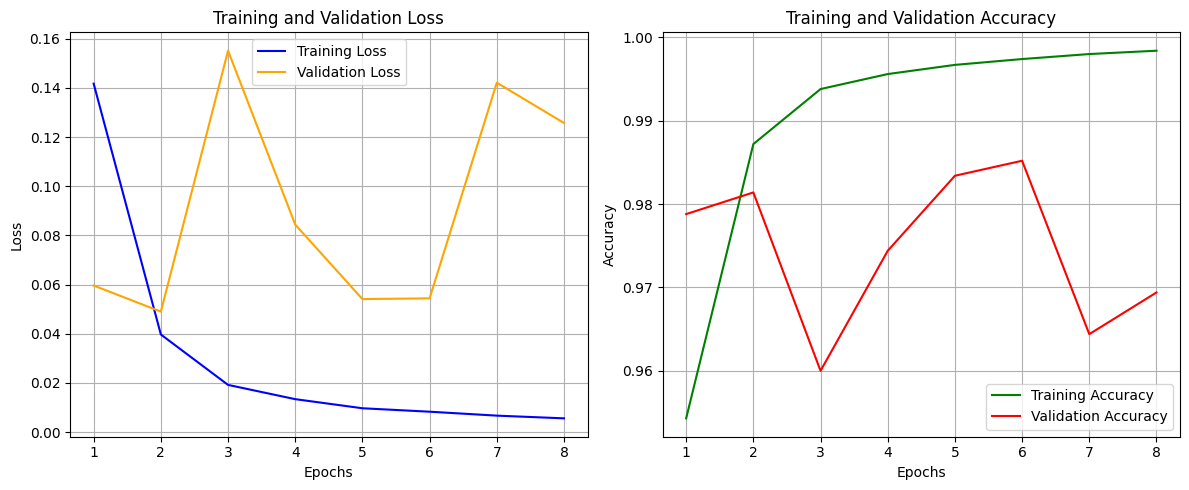

In [25]:
import matplotlib.pyplot as plt

# Assuming you have tracked these during training
# These lists should be populated during training
train_losses = [0.1417,0.0397,0.0192,0.0134,0.0097,0.0083,0.0067,0.0056]  # Populate this during training
val_losses = [0.0596,0.0490,0.1551,0.0844,0.0541,0.0544,0.1421,0.1257]  # Stores average validation losses for each epoch
val_accuracies = [0.9788,0.9814,0.9600,0.9744,0.9834,0.9852,0.9644,0.9694]
train_accuracies = [0.9543,0.9872,0.9938,0.9956,0.9967,0.9974,0.9980,0.9984]  # Populate this during training
 # Populate this during validation

epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()


Evaluating Test Set: 100%|█| 131/131 [02:59<00:00,  1.37s/batch, accuracy=0.9678

Test Loss: 0.1279, Test Accuracy: 0.9678


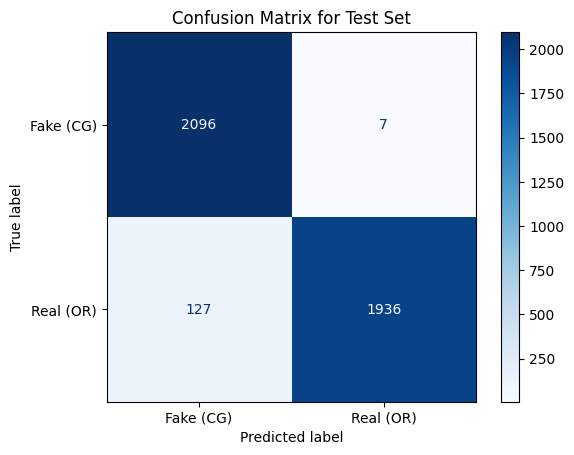


Classification Report:

              precision    recall  f1-score   support

   Fake (CG)       0.94      1.00      0.97      2103
   Real (OR)       1.00      0.94      0.97      2063

    accuracy                           0.97      4166
   macro avg       0.97      0.97      0.97      4166
weighted avg       0.97      0.97      0.97      4166



In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Updated evaluation function to return predictions and true labels
def evaluate_with_metrics(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    criterion = nn.BCELoss()  # Same loss function used in training

    with torch.no_grad():
        with tqdm(total=len(test_dataloader), desc="Evaluating Test Set", unit="batch") as pbar:
            for batch in test_dataloader:
                input_ids, attention_mask, labels = batch
                # Forward pass
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.squeeze(), labels.float())
                test_loss += loss.item()

                # Binary threshold for predictions
                preds = (outputs.squeeze() > 0.5).float()
                all_preds.extend(preds.cpu().numpy())  # Collect predictions
                all_labels.extend(labels.cpu().numpy())  # Collect true labels

                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

                # Update progress bar
                avg_test_loss = test_loss / (pbar.n + 1)
                running_test_accuracy = correct_predictions / total_predictions
                pbar.set_postfix(loss=f"{avg_test_loss:.4f}", accuracy=f"{running_test_accuracy:.4f}")
                pbar.update(1)

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = correct_predictions / total_predictions
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Return predictions and true labels for further metrics
    return np.array(all_preds), np.array(all_labels)

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Function to print the classification report
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:\n")
    print(report)

# Evaluate the model and get predictions and true labels
y_pred, y_true = evaluate_with_metrics(model, test_dataloader)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names=['Fake (CG)', 'Real (OR)'])

# Print the classification report
print_classification_report(y_true, y_pred, class_names=['Fake (CG)', 'Real (OR)'])
